In [1]:
#@title Install TensorFlow Datasets
!pip install -U tensorflow_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow_datasets
    Found existing installation: tensorflow-datasets 4.9.6
    Uninstalling tensorflow-datasets-4.9.6:
      Successfully uninstalled tensorflow-datasets-4.9.6


In [2]:
#@title Import the necessary dependencies
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import numpy as np
import matplotlib.pyplot as plt
import math
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
#@title load the dataset from tensorflow_datasets
dataset, metadata = tfds.load('fashion_mnist', as_supervised = True, with_info = True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
#@title Explore the dataset
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of testing examples: {}".format(num_test_examples))

Number of training examples: 60000
Number of testing examples: 10000


In [6]:
#@title Preprocess the data by creating a normalization function that normalizes the input image to a range 0,1
def normalize_image(images, labels):
    images = tf.cast(images, tf.float32)
    images /=255
    return images, labels

#the map function applies the normalization function to each image in the train and test datasets
train_dataset = train_dataset.map(normalize_image)
test_dataset = test_dataset.map(normalize_image)

#caching the dataset into memory to make training faster
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()


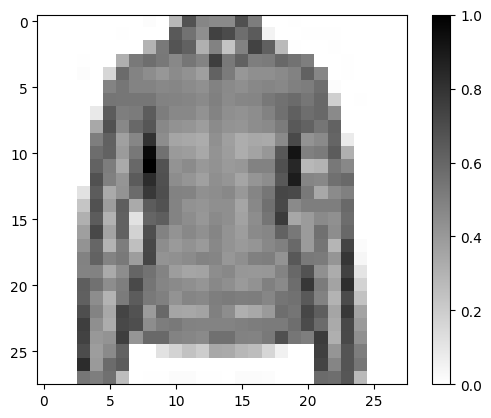

In [9]:
#@title Exploring the processed data
#taking and visualizing one image

for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))


#plotting the image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

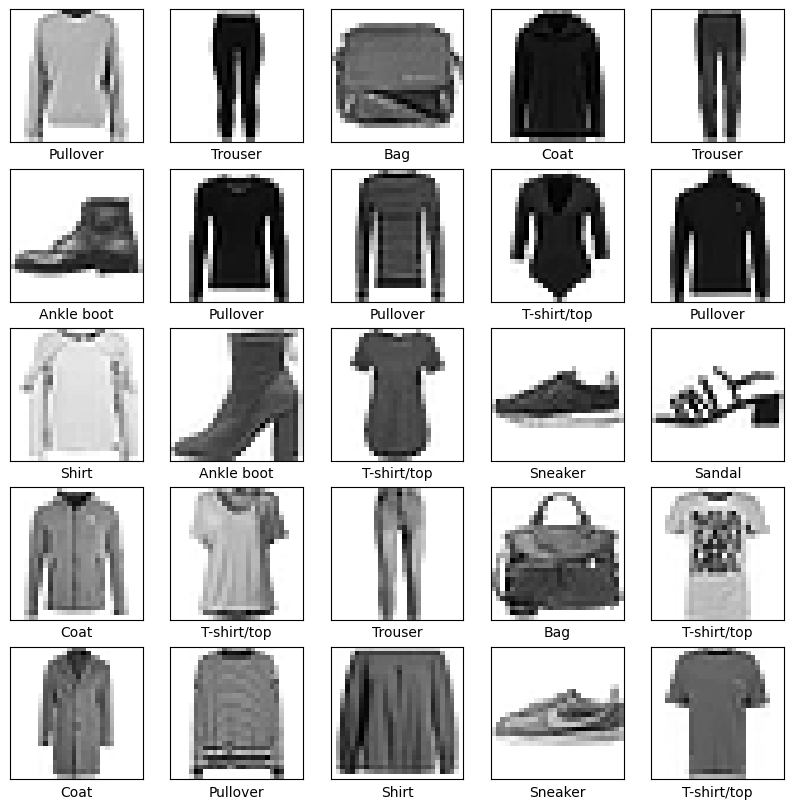

In [10]:
#@title Display the first 25 Images

plt.figure(figsize = (10,10))
for i, (image,label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

In [11]:
#@title Build the Model
#setting up the layers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28,1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)


])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#@title Compile the Model
model.compile(optimizer = 'adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics = ['accuracy']

                      )

In [13]:
#@title Train the model
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7819 - loss: 0.6317
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8616 - loss: 0.3842
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8777 - loss: 0.3359
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8833 - loss: 0.3200
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8894 - loss: 0.3043


In [14]:
#@title Evaluate the Model

test_loss, test_accuracy = model.evaluate(test_dataset, steps = math.ceil(num_test_examples/32))
print("Accuracy on the test data:", test_accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8758 - loss: 0.3521
Accuracy on the test data: 0.8716999888420105


In [16]:
#@title Make Predictions and Explore
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)
predictions[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


array([1.7869712e-05, 7.6200983e-08, 8.2510915e-03, 1.7338824e-07,
       9.8103356e-01, 6.8955237e-09, 1.0685355e-02, 2.2442633e-08,
       1.1949188e-05, 3.0843789e-10], dtype=float32)

In [17]:
np.argmax(predictions[0])

4

In [19]:
class_names[6]

'Shirt'

In [20]:
#@title Graphing to look at the full set of 10 class set predictions
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

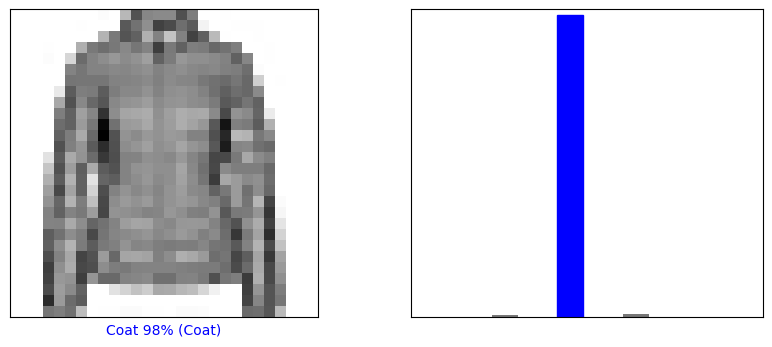

In [24]:
#@title Looking at the 0th image, prediction, and prediction array
i = 0
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

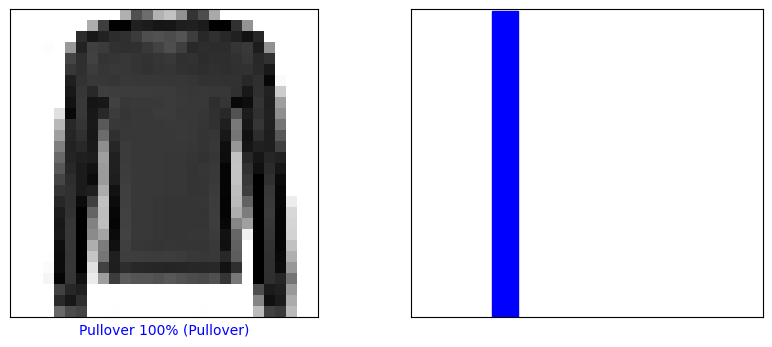

In [25]:
i = 12
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

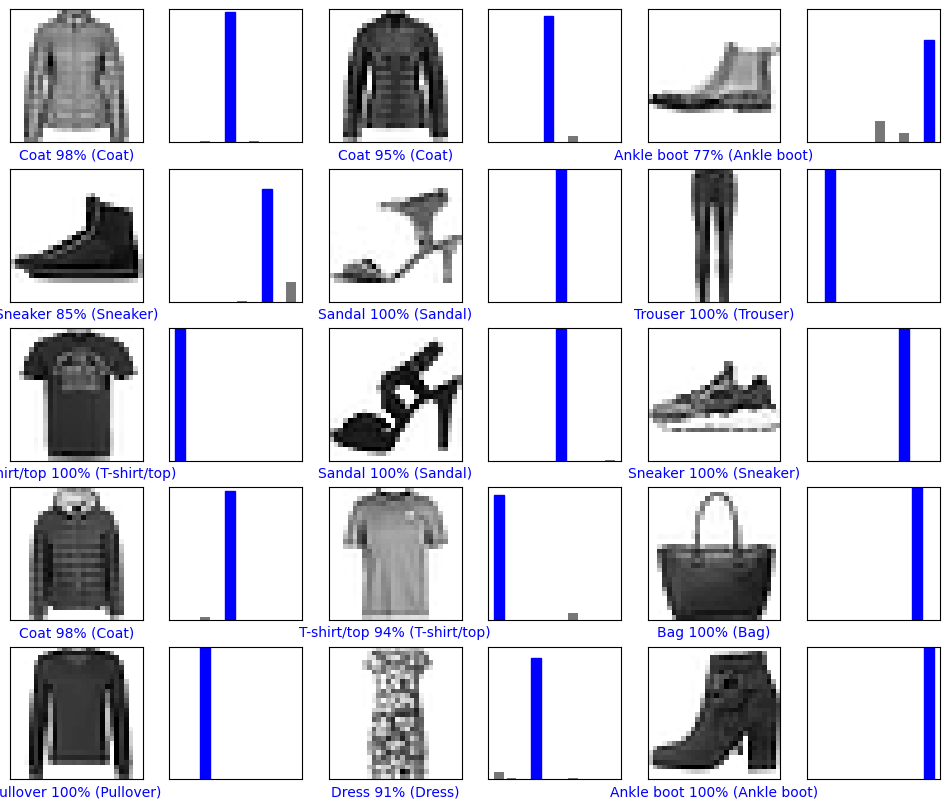

In [26]:
#@title Plotting different images
#Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
[[1.7869712e-05 7.6200983e-08 8.2510915e-03 1.7338809e-07 9.8103356e-01
  6.8955370e-09 1.0685361e-02 2.2442588e-08 1.1949188e-05 3.0843789e-10]]


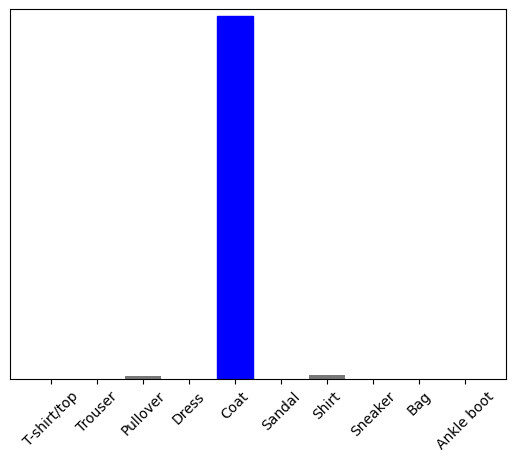

In [27]:
img = test_images[0]
img = np.array([img])
predictions_single = model.predict(img)
print(predictions_single)

plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)